### First step in gap analysis is to determine the AEP based on operational data.

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Import required packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from project_ENGIE import Project_Engie
from operational_analysis.methods import turbine_long_term_gross_energy

In the call below, make sure the appropriate path to the CSV input files is specfied. In this example, the CSV files are located directly in the 'examples/operational_AEP_analysis/data' folder.

In [7]:
# Load plant object
project = Project_Engie('./data/la_haute_borne/')

In [8]:
# Prepare data
project.prepare()

INFO:project_ENGIE:Loading SCADA data
INFO:operational_analysis.types.timeseries_table:Loading name:la-haute-borne-data-2014-2015
INFO:project_ENGIE:SCADA data loaded
INFO:project_ENGIE:Timestamp QC and conversion to UTC
INFO:project_ENGIE:Correcting for out of range of temperature variables
INFO:project_ENGIE:Flagging unresponsive sensors
INFO:project_ENGIE:Converting field names to IEC 61400-25 standard
INFO:operational_analysis.types.timeseries_table:Loading name:plant_data
INFO:operational_analysis.types.timeseries_table:Loading name:plant_data
INFO:operational_analysis.types.timeseries_table:Loading name:merra2_la_haute_borne
INFO:operational_analysis.types.timeseries_table:Loading name:era5_wind_la_haute_borne


In [9]:
project._scada.df.columns

Index(['id', 'wrot_BlPthAngVal1_avg', 'wmet_wdspd_avg', 'wmet_VaneDir_avg',
       'wmet_EnvTmp_avg', 'wyaw_YwAng_avg', 'wmet_HorWdDir_avg', 'wtur_W_avg',
       'energy_kwh'],
      dtype='object')

In [10]:
ta = turbine_long_term_gross_energy.TurbineLongTermGrossEnergy(project)

INFO:operational_analysis.methods.turbine_long_term_gross_energy:Initializing TurbineLongTermGrossEnergy Object
INFO:operational_analysis.methods.turbine_long_term_gross_energy:Processing SCADA data into dictionaries by turbine (this can take a while)


In [12]:
ta.run(reanal_subset = ['era5', 'merra2'], 
       max_power_filter = 0.85, 
       wind_bin_thresh = 2, 
       correction_threshold = 0.90, 
       enable_plotting = False,
       plot_dir = None)

INFO:operational_analysis.methods.turbine_long_term_gross_energy:Filtering turbine data
INFO:operational_analysis.methods.turbine_long_term_gross_energy:Processing reanalysis data to daily averages
INFO:operational_analysis.methods.turbine_long_term_gross_energy:Processing scada data to daily sums
4it [00:00, 24.56it/s]
INFO:operational_analysis.methods.turbine_long_term_gross_energy:Setting up daily data for model fitting
INFO:operational_analysis.methods.turbine_long_term_gross_energy:Fitting model data
INFO:operational_analysis.methods.turbine_long_term_gross_energy:Applying fitting results to calculate long-term gross energy
INFO:operational_analysis.methods.turbine_long_term_gross_energy:Run completed


#### Examine results

In [17]:
# Long-term annual TIE for whole plant
print('Long-term turbine ideal energy is %s GWh/year' %np.round(ta._plant_gross/1e6,1))

Long-term turbine ideal energy is 13.7 GWh/year


#### Let's look how the filtering algorithms worked:

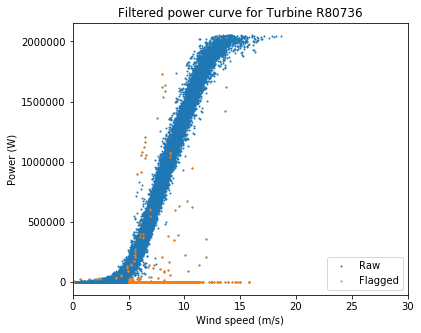

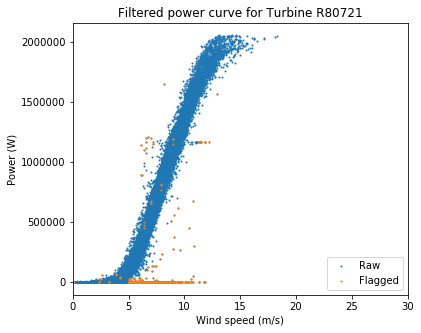

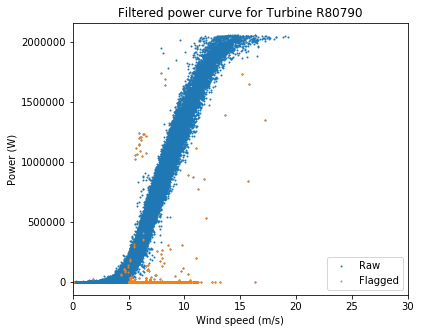

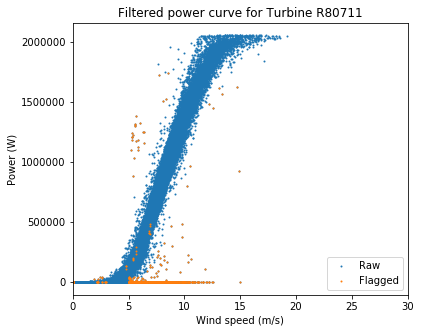

In [19]:
ta.plot_filtered_power_curves(save_folder = "/Users/moptis/Documents/temp/", output_to_terminal = True)

### Overall these are very clean power curves, and the filtering algorithms seem to have done a good job of catching the most egregious outliers.

#### Let's look at the daily data and how well the power curve fit worked

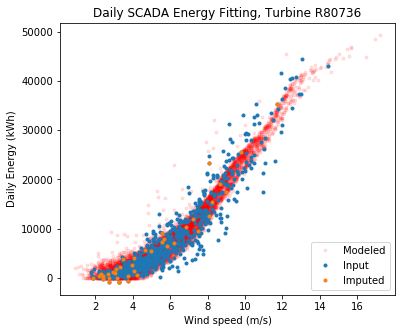

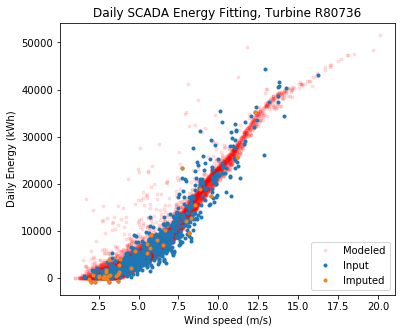

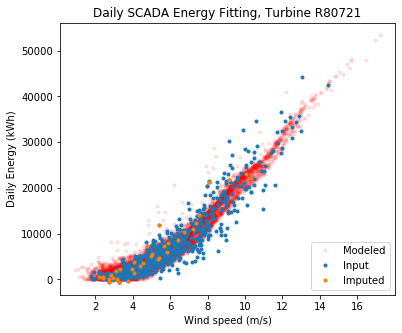

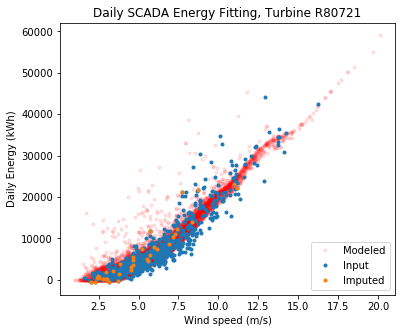

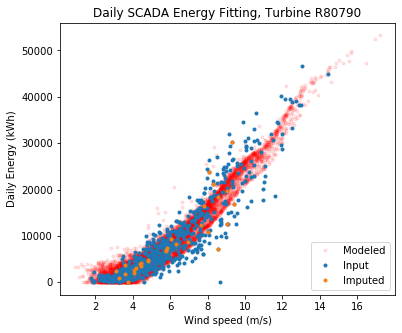

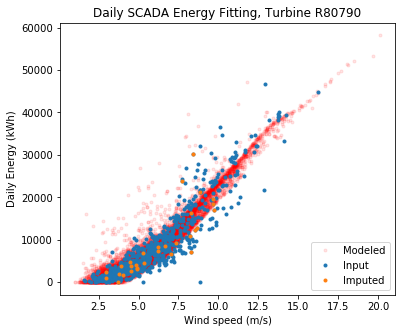

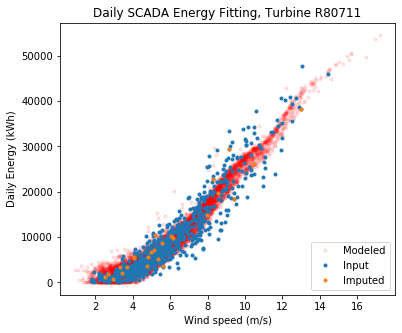

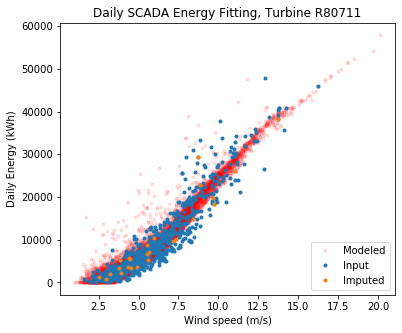

In [20]:
ta.plot_daily_fitting_result(save_folder = "/Users/moptis/Documents/temp/", output_to_terminal = True)

#### Overall the fit looks good. The modeled data sometimes estimate higher energy at low wind speeds compared to the observed, but keep in mind the model fits to long term wind speed, wind direction, and air density, whereas we are only showing the relationship to wind speed here.